[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/CMU-IDeeL/CMU-IDeeL.github.io/blob/master/F25/document/Recitation_0_Series/0.12/0_12_Dataloaders.ipynb)

# Recitation 0.15 : Dataloaders

The purpose of this notebook is to understand the main concepts behind the PyTorch DataLoader and see a pedogogical, trivial example of using DataLoaders. Additionally, DataLoader customization (the collate function) and GPU memory efficiency will be discussed.

PyTorch Reference: https://pytorch.org/docs/stable/data.html

# Contents

1. Introduction to PyTorch DataLoader
2. Initializing a DataLoader Object
3. On-the-Fly Data Loading
4. Handling Different Batching Strategies
5. Creating a Custom Batch Sampler
6. Customizing Data Loading with the Collate Function
7. Leveraging Multi-Process Data Loading and Pin Memory

# PyTorch DataLoader

The main idea behind the data loader is illustrated in the figure below 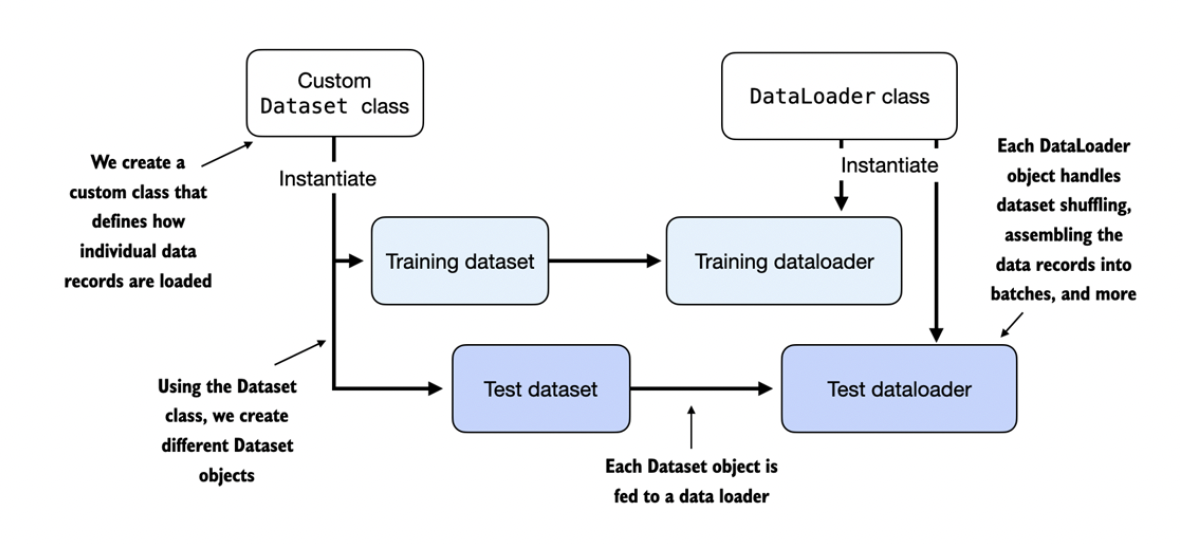
Source (Sebastian Rascka :Building A Large language from Scratch).

Pytorch implements a Dataset and a Dataloader class.
* Dataset class - used to instantiate objects that define how each data record is loaded.
* Dataloader - handles how data is shuffled and handled into batches.

## Why DataLoader?
### Batching
Batching processes the data in batches, which helps to leverage hardware capabilities by parallel processing to improve efficiency. It allows the model to process data in smaller chunks (batches) instead of the entire dataset at once. This reduces the memory footprint required during training, making it feasible to train on larger datasets or models with limited memory resources. During training, the model updates its internal parameters based on the gradients calculated from the loss function. Batching provides a balance between computational efficiency and the accuracy of gradient updates.
### Shuffling
Shuffling prevents the model from biased learning of dataset. Shuffling the data order in each epoch ensures the model encounters data points in different combinations, forcing it to learn generalizable features rather than memorizing specific data order. Thus, it prevents from Overfitting. Shuffling helps the model avoid getting stuck in local minima during training by exposing it to a more diverse set of data combinations in each epoch to provide more stability. Example: In binary classification, the data could be 1, 1, 1, ..., 1, 0, 0, 0, ..., 0. This could cause overfitting and model may just output one label without shuffling.
### Data Processing
Processing helps to transform data to improve model stability and robustness. Processing steps like normalization, scaling, and handling missing values ensure the data is clean and suitable for the model's input format. This improves the quality of data fed to the model, leading to better training outcomes. Data augmentation techniques like random cropping, flipping, or adding noise can be applied during processing to artificially increase the size and diversity of the training data. This helps the model become more robust to variations in real-world data and improve generalization.

- Now that we know what pytorch tensors are, lets start by creating a simple sampel of training examples with two features each, and a tensor containing the respective labels of the training examples. (class 0 and class 1)
- We will also create two test examples belonging to class 0 and class 1.  

In [26]:
import torch
import torchvision
import numpy as np

In [27]:
# Training set with two features
X_train = torch.tensor([[1.0, 2.0],
                        [3.0, 4.0],
                        [5.0, 6.0],
                        [7.0, -8.0],
                        [5.7, 2.5]
                        ])
y_train = torch.tensor([0, 0, 0, 1, 1]) #

# Two examples of the Test set
X_test = torch.tensor([[9.0, 10.0],
                       [11.0, 12.0]
                       ])
# Labels of the test set
y_test = torch.tensor([0, 1])
# We will start small lets call this our SimpleDataset class .
# Its purpose is to help us instantiate the SimpleDataloader.

### Defining a custom Dataset Class

In [28]:
from torch.utils.data import Dataset

class SimpleDataset(Dataset):
  def __init__(self, X, y):
    self.features = X
    self.labels = y

  def __getitem__(self, index):
    one_x = self.features[index]
    one_y = self.labels[index]
    return one_x, one_y

  def __len__(self):
    return self.labels.shape[0]
# NOTE : In most cases, we have different classes for train and test.
# Instantiate this object
train_ds = SimpleDataset(X_train, y_train)
test_ds = SimpleDataset(X_test, y_test)

In [29]:
train_ds.__len__()

5

There are 3 main components of the custom Dataset class.
* __ init__ constructor : We set up attributes that we will use later in the __getitem__ and __len__ methods. These could be filepaths, file objects,database connectors etc Mostly we use these to define the features and labels of your dataset. These are placeholders for the real data.
* __ getitem__ method : We define instructions for returning exactly one item from the dataset via an index. This means the features and labels of a single training or testing instance. The dataloader provides this index.
* __ len__ method: Contains instructions for retieving the length of the dataset. Here we can use .shape attribute of the tensor returning the number of rows in the feature array or we can use len() function to get the actual number of items in the tensor object. You can verify this by just typing


```
print(len(train_ds))
```
The result is
```
5
```
Now that we have defined a Pytorch Dataset class to use for our simple dataset, lets use Pytorch's DataLoader class to sample from it


### Instantiating a simple dataloader

In [33]:
from torch.utils.data import DataLoader

torch.manual_seed(123) # Sets a seed for generating random numbers on all devices

train_loader = DataLoader(dataset=train_ds,
                          batch_size=2,
                          shuffle=True,
                          num_workers=0, drop_last=True)
test_loader = DataLoader(dataset=test_ds,
                         batch_size=2,
                         shuffle=False,
                         num_workers=0)
# NOTE: The Simpledataset instance created (train_ds,test_ds) earlier serves as input to the dataloader.
# NOTE: We choose whether to shuffle or not to shuffle the data. Brain teaser (Why do we choose not to shuffle the test set ?)
# NOTE: Num_workers helps us set the number of background processes



In [34]:
# After instantiating the train data_loader, we can iterate over it as shown below
for idx, (x,y) in enumerate(train_loader):
  print(f" Batch {idx + 1}: \n", x, y)

 Batch 1: 
 tensor([[ 7., -8.],
        [ 3.,  4.]]) tensor([1, 0])
 Batch 2: 
 tensor([[1., 2.],
        [5., 6.]]) tensor([0, 0])


#### Epoch.
As we can see in the output above the train loader iterates over the whole training dataset visiting each training example just once. This is known as an **epoch**. We can say that **1 epoch** is one complete pass of the training dataset through the algorithm.

#### Batch and Batch size.

A batch is composed of multiple training examples. Therefore **batch_size** is the number of training examples in one forward/backward pass. The higher the batch size, the more memory space you will need.


**No of iterations = No of batches**: number of passes, each pass using batch_size number of examples. Example: With 100 training examples and batch size of 20 it will take 5 iterations to complete 1 epoch.

Note that we specified a batch of 2 above, since we have 5 training examples (which is not divisible by 2), the 3rd batch will contain a single example. NOTE: Having a substantially smaller batch as the last batch in a training epoch can disturb the convergence during training. To prevent this, we recommend to set ```drop_last = True``` which will drop the last batch in each epoch.








#### Shuffle
Since we seeded the random number generator using```torch.manual_seed(123)``` above, if you iterate over the dataset a second time, you will see that the shuffling order will change. This prevents the DNN from getting caught in repetitive update cycles in training (Neural Nets love memorizing !!) we are trying to prevent that.

#### Num_workers.
The diagram below illustrates this.
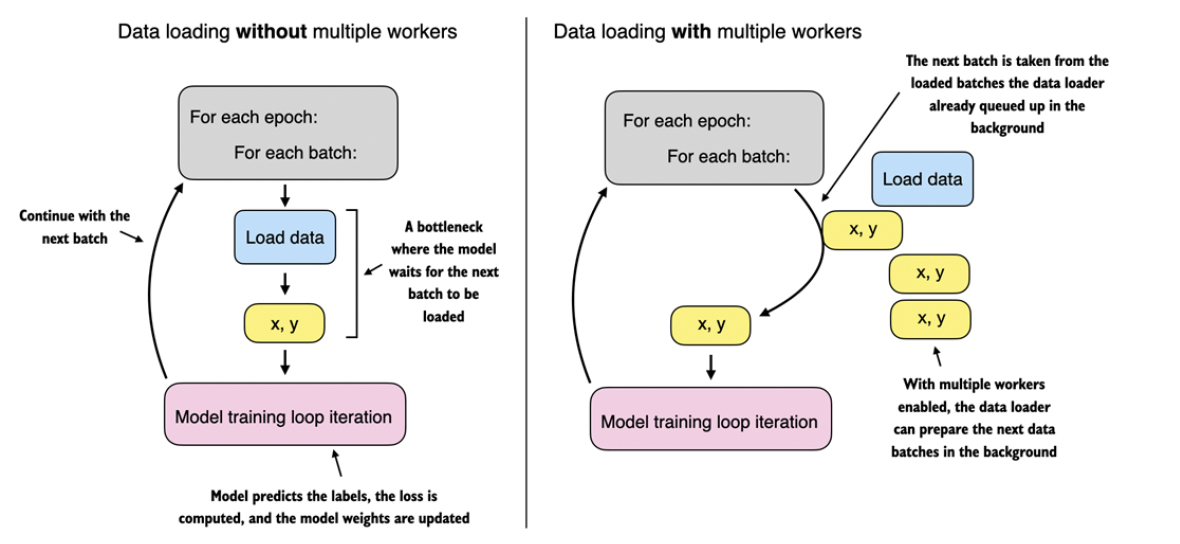
Source (Sebastian Raschka, Building a Large Language Model from scratch).
Setting the ```num_workers```in the DataLoader is crucial for parallelizing data loading and preprocessing. When num_workers is set to 0, the data loading will be done in the main process and not in separate worker processes.
This might seem unproblematic, but it can lead to significant slowdowns during model training when we train larger networks on a GPU. Here, the model sits idle until the next batch is loaded as illustrated in the left subpanel. If multiple workers are enabled, the data loader can already queue up the next batch in the background as shown in the right subpanel.

If youre working with very small datasets, setting num_workers to one or larger maybe unnecessary since the total training time takes only fractions of seconds.

## Manual data feed



```
x = a list of 10000 input samples
y = a list of 10000 target labels corresponding to x

# Load data manually in batches
for epoch in range(10):
    for i in range(n_batches):
        # Local batches and labels
        local_X, local_y = x[i*n_batches:(i+1)*n_batches,], y[i*n_batches:(i+1)*n_batches,]

        # Your model
        [...]
```



# Dataloaders (PyTorch)

Documentation:
[Read Docs](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html)

The Dataset retrieves our dataset's features and labels one sample at a time. While training a model, we typically want to

1.   Pass samples in “minibatches”
2.   Reshuffle the data at every epoch to reduce model overfitting
3.   Use Python's multiprocessing to speed up data retrieval

# 1- Sample DataLoader

Handles data loading logic


In [35]:
from torch.utils.data import Dataset, DataLoader, Sampler
import os
from PIL import Image
import numpy as np
# Dataloader will use dataset to create batches, process data etc.
# Visit Dataset Recitation for more details

class MyDataset(Dataset):
    # constructor, in this case it contains the data
    def __init__(self, xs, ys):
        self.input = xs  # Fix: assign xs to self.input
        self.target = ys  # Fix: assign ys to self.target

    # returns the length of the dataset
    def __len__(self):
        return len(self.input)

    # returns the item at index i
    def __getitem__(self, i):
        return self.input[i], self.target[i]

You want to train a model to learn that the target = 2 x input, and hence created the following dataset:

In [37]:
# We are creating a dummy dataset to test Dataloaders
input = [i for i in range(10)] # TODO: give a list of 10 values as features ....
target = [i * 2 for i in range(10)] # TODO give a list of 20 values as target values with a skip step of 2 (assuming 10 values to match input length)
print('input values: ', input)
print('target values: ', target)

# Create an instance of MyDataset class
dataset = MyDataset(input, target)
print("The second sample is: ", dataset[2]) # returns the tuple (input[2], target[2])
# This is basically same as
print("The second sample is: ", dataset.__getitem__(2))
# Which the dataloader needs

input values:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
target values:  [0, 2, 4, 6, 8, 10, 12, 14, 16, 18]
The second sample is:  (2, 4)
The second sample is:  (2, 4)


# 2- Initializing a DataLoader Object
### Let's look at different ways of creating the Dataloader object using the Dataloader class


In [38]:
# batch size of 1, so we the size of x and y is 1 and no shuffling
for x, y in DataLoader(dataset):
    print(f"batch of inputs: {x}, batch of labels: {y}")

batch of inputs: tensor([0]), batch of labels: tensor([0])
batch of inputs: tensor([1]), batch of labels: tensor([2])
batch of inputs: tensor([2]), batch of labels: tensor([4])
batch of inputs: tensor([3]), batch of labels: tensor([6])
batch of inputs: tensor([4]), batch of labels: tensor([8])
batch of inputs: tensor([5]), batch of labels: tensor([10])
batch of inputs: tensor([6]), batch of labels: tensor([12])
batch of inputs: tensor([7]), batch of labels: tensor([14])
batch of inputs: tensor([8]), batch of labels: tensor([16])
batch of inputs: tensor([9]), batch of labels: tensor([18])


# 3- On-the-Fly Data Loading

The key to handling large datasets is to load and process data in batches, only when needed. This strategy, known as on-the-fly or lazy loading, can be implemented in PyTorch by customizing the ```Dataset``` class.

In [39]:
class LargeImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.image_dir, self.image_files[idx]) # This is more memory efficient.
        image = Image.open(img_name).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image

# Usage
image_dir = './'

# on-the-fly augmantation
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256, 256)),
    torchvision.transforms.ToTensor()
])
large_dataset = LargeImageDataset(image_dir, transform=transform)

# 4- Handling Different Batching Strategies

In [40]:
# batch size of 4, so x and y both have a size of 4, no shuffling
for x, y in DataLoader(dataset, batch_size=4):
    print(f"batch of inputs: {x}, batch of labels: {y}")

batch of inputs: tensor([0, 1, 2, 3]), batch of labels: tensor([0, 2, 4, 6])
batch of inputs: tensor([4, 5, 6, 7]), batch of labels: tensor([ 8, 10, 12, 14])
batch of inputs: tensor([8, 9]), batch of labels: tensor([16, 18])


In [46]:
# batch size of 4, so x and y both have a size of 4, random shuffle
for x, y in DataLoader(dataset, batch_size=4, shuffle=True):
    print(f"batch of inputs: {x}, batch of labels: {y}")

batch of inputs: tensor([4, 3, 8, 1]), batch of labels: tensor([ 8,  6, 16,  2])
batch of inputs: tensor([6, 0, 9, 2]), batch of labels: tensor([12,  0, 18,  4])
batch of inputs: tensor([7, 5]), batch of labels: tensor([14, 10])


In [47]:
# batch size of 4, drop the last batch with less than 4 samples
for x, y in DataLoader(dataset, batch_size=4, shuffle=True, drop_last=True):
    print(f"batch of inputs: {x}, batch of labels: {y}")

batch of inputs: tensor([5, 6, 3, 1]), batch of labels: tensor([10, 12,  6,  2])
batch of inputs: tensor([2, 0, 9, 4]), batch of labels: tensor([ 4,  0, 18,  8])



# 5- Creating a Custom [Batch Sampler](https://pytorch.org/docs/stable/data.html#torch.utils.data.Sampler)

In PyTorch, a Batch Sampler is used to define how batches are formed from the dataset. The default behavior is to sequentially or randomly sample elements to form a batch. However, there are scenarios where you may need more control over how batches are created, such as when dealing with sequences of varying lengths or when implementing certain types of sampling strategies like stratified sampling for imbalanced data. In such cases, a custom batch sampler is invaluable.


A custom batch sampler in PyTorch is a class that implements two key methods: ```__iter__ ``` and ```__len__```. The ```__iter__``` method yields a list of indices representing a single batch, and ```__len__``` returns the number of batches expected in an epoch.



In [48]:
# Create an object of the custom dataset class, here we will create a toy dataset that contains odd and even numbers along with their labels
class EvenOddNumberDataset(Dataset):
    def __init__(self, start, end):

        self.numbers = list(range(start, end))

    def __len__(self):

        # Return the total number of items in the dataset.

        return len(self.numbers)

    def __getitem__(self, idx):

        # Retrieve an item by its index.

        number = self.numbers[idx]
        label = 1 if number % 2 != 0 else 0  # 1 for odd, 0 for even
        return number, label

# Usage example
start = 0
end = 100
dataset = EvenOddNumberDataset(start, end)

# Example of accessing the dataset
for i in range(5):
    print(dataset[i])


(0, 0)
(1, 1)
(2, 0)
(3, 1)
(4, 0)


In [49]:
class MyBatchSampler(Sampler):
    def __init__(self, dataset, batch_size):

        # Initialize the batch sampler.

        self.dataset = dataset
        self.batch_size = batch_size
        self.labels = [label for _, label in dataset]
        self.class_indices = self._get_class_indices()
        self.num_batches = np.ceil(len(self.dataset) / batch_size)

    def _get_class_indices(self):

        # Group dataset indices by class (even/odd).

        class_indices = {}
        for idx, label in enumerate(self.labels):
            if label not in class_indices:
                class_indices[label] = []
            class_indices[label].append(idx)
        return class_indices

    def __iter__(self):

        # Iterator method to yield batches.

        for _ in range(int(self.num_batches)):
            batch = []
            for class_idx in self.class_indices.values():
                samples_per_class = int(self.batch_size / len(self.class_indices))
                selected_indices = np.random.choice(class_idx, samples_per_class, replace=False)
                batch.extend(selected_indices)
            np.random.shuffle(batch)
            yield batch

    def __len__(self):

        # Return the total number of batches.

        return int(self.num_batches)


In [50]:
batch_sampler = MyBatchSampler(dataset, batch_size=16)
data_loader = DataLoader(MyDataset, batch_sampler=batch_sampler)


# 6- Collate function

A dataloader parameter which can be customized to achieve custom automatic batching.

You may apply some transformation in the collate function;
One can choose to apply transformation in the collate function instaed of dataset class if transformation needs to be applied on batches.
Also, since data loader support multiprocess through multi-workers, hence ```collate_fn()``` also can take advantage of multi-workers performance speed up.

<div style="display: flex; justify-content: center;">
  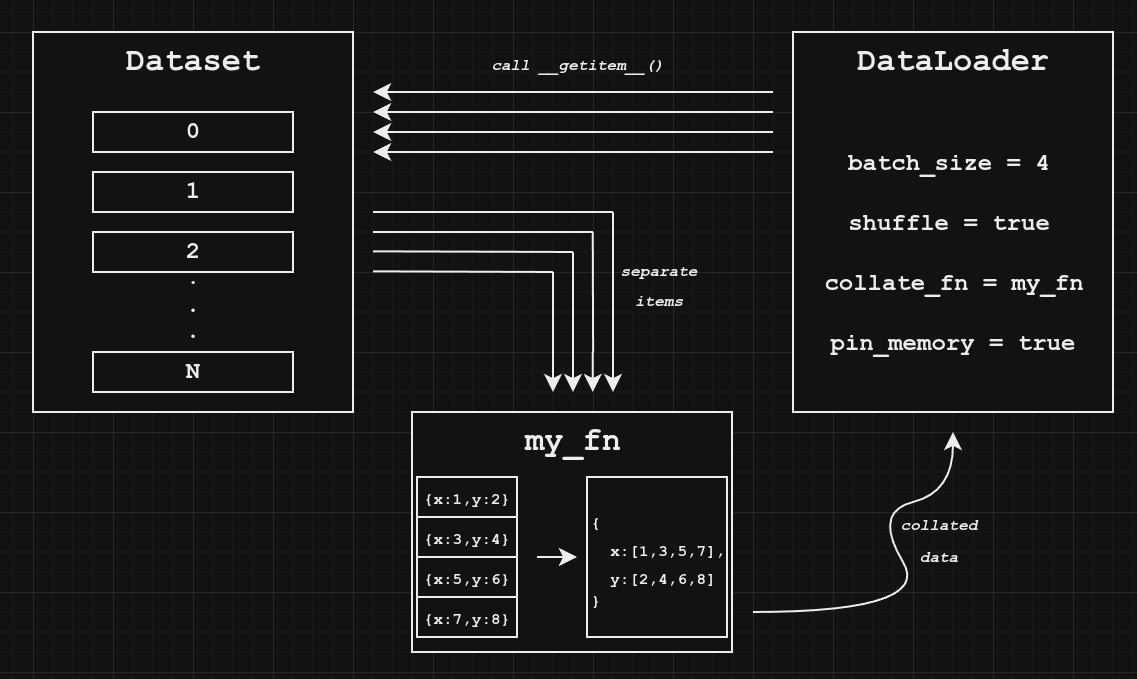
</div>

Source (Luke Salamone, Custom PyTorch Collate Function)

In [52]:
# Create an object of the custom dataset class
class MyNormalDataset(Dataset):
    # constructor, in this case it contains the data
    def __init__(self, xs, ys):
        self.input = input
        self.target = target

    # returns the length of the dataset
    def __len__(self):
        return len(self.input)

    # returns the item at index i
    def __getitem__(self, i):
        return self.input[i], self.target[i]# create a dict of arguments, another way of passing arguments

    def collate_fn(self, batch):
        x, y = zip(*batch)
        x_mean = np.mean(x)
        x_std = np.std(x)
        x_normal = (x-x_mean)/(x_std+1e-9)
        return x_normal, y


input = np.array(list(range(10)))
target = np.array(list(range(0, 20, 2)))
print('input values: ', input)
print('target values: ', target)

# Create an instance of MyDataset class
dataset = MyNormalDataset(input, target)
# Use the custom collate_fn
# pass the arguments
train_dataloader_custom = DataLoader(dataset, batch_size=5, shuffle=True, collate_fn= dataset.collate_fn)

# Display collated inputs and labels.
for i, (x, y) in enumerate(train_dataloader_custom):
    print(f"batch of inputs: {x}, batch of labels: {y}")


input values:  [0 1 2 3 4 5 6 7 8 9]
target values:  [ 0  2  4  6  8 10 12 14 16 18]
batch of inputs: [ 1.14873305  0.78975397  0.4307749  -1.00514142 -1.3641205 ], batch of labels: (np.int64(18), np.int64(16), np.int64(14), np.int64(6), np.int64(4))
batch of inputs: [-1.38218948  1.2094158   0.77748158  0.34554737 -0.95025527], batch of labels: (np.int64(0), np.int64(12), np.int64(10), np.int64(8), np.int64(2))


## 7- Single and multi-process loading

We can use the ```num_workers``` to specify how many subprocesses to use for data loading. \
0 means that the data will be loaded in the main process. \

In [53]:
# 2 subprocesses
train_dataloader_fast = DataLoader(dataset, batch_size=5, shuffle=True, collate_fn= dataset.collate_fn, num_workers=2)

In [54]:
# The maximum subprocesses you can use depends on the machine you are training on
# you can try to increase it until you see a warning.

train_dataloader_fast = DataLoader(dataset, batch_size=5, shuffle=True, collate_fn= dataset.collate_fn, num_workers=4)

Use ```pin_memory``` to copy Tensors into device/CUDA pinned memory before returning them -> faster processing.

In [25]:
train_dataloader_faster = DataLoader(dataset,
                                     batch_size=5,
                                     shuffle=True,
                                     collate_fn= dataset.collate_fn,
                                     num_workers=4,
                                     pin_memory= True)

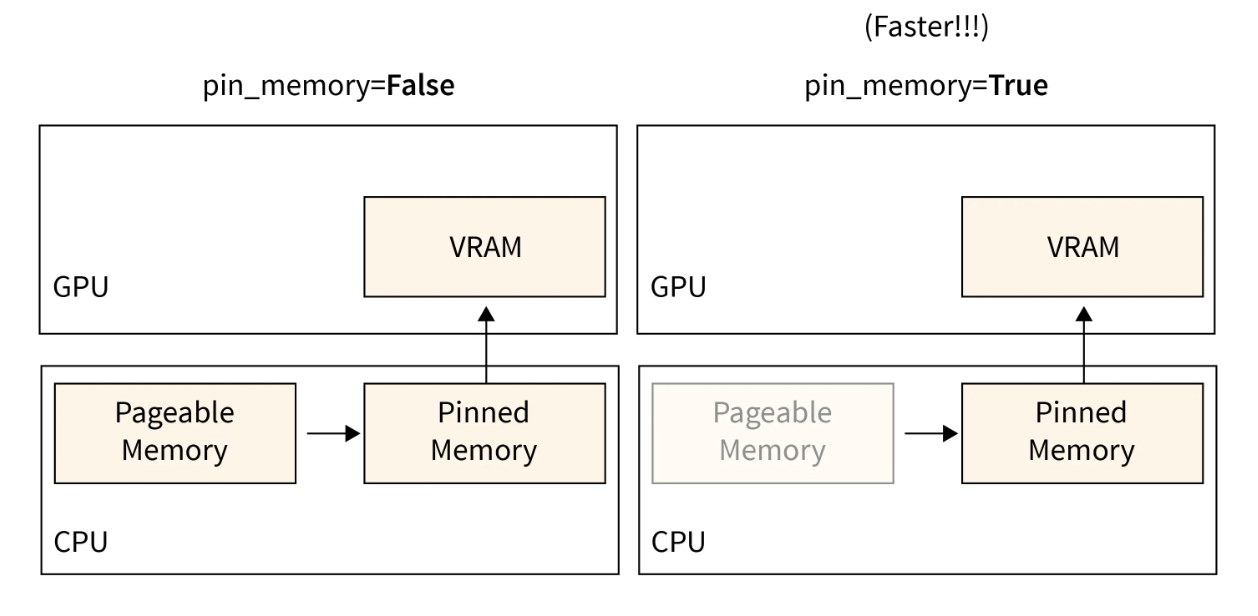

Source (Srishti Gureja, How to Create a Dataloader in PyTorch?)